In [1]:
import pickle

# load
with open('../data/NAVER_N_V_train.txt', 'rb') as rd:
    train_docs = pickle.load(rd)
    
with open('../data/NAVER_N_V_test.txt', 'rb') as rd:
    test_docs = pickle.load(rd)

In [2]:
from collections import namedtuple

TaggedDocument = namedtuple('TaggedDocument', 'words tags')

tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

---

In [3]:
from gensim.models import doc2vec

doc_vectorizer = doc2vec.Doc2Vec.load('./Model/NAVER_NV_DBOW_win20_size500_hs')

In [4]:
import numpy as np

train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]

test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]

train_x_np = np.asarray(train_x)
test_x_np = np.asarray(test_x)

In [5]:
labeling = train_y+test_y
labeling_np = np.asarray(labeling, dtype=str)

a , b = np.unique(labeling_np, return_inverse=True )
c , d = np.unique(labeling_np[160000:], return_counts=True )

train_label_np=a[b][:160000]
test_label_np=a[b][160000:]

train_y_np=b[:160000].astype(int)
test_y_np=b[160000:].astype(int)

In [6]:
nb_classes = 48
train_y_np = np.eye(nb_classes)[train_y_np]
test_y_np = np.eye(nb_classes)[test_y_np]

- - -

In [7]:
# Lab 10 MNIST and High-level TF API
import tensorflow.contrib as contrib
from tensorflow.contrib.layers import fully_connected, batch_norm, dropout, variance_scaling_initializer
from tensorflow.contrib.framework import arg_scope
import tensorflow as tf
import random
from datetime import datetime

In [8]:
# parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 128
keep_prob = 0.5
He = variance_scaling_initializer()

In [9]:
tf.reset_default_graph()

# input place holders
X = tf.placeholder(tf.float32, [None, 500])
Y = tf.placeholder(tf.float32, [None, 48])
train_mode = tf.placeholder(tf.bool, name='train_mode')

In [10]:
# fully_connected(
#     inputs,
#     num_outputs,
#     activation_fn=tf.nn.relu,
#     normalizer_fn=None,
#     normalizer_params=None,
#     weights_initializer=initializers.xavier_initializer(),
#     weights_regularizer=None,
#     biases_initializer=tf.zeros_initializer(),
#     biases_regularizer=None,
#     reuse=None,
#     variables_collections=None,
#     outputs_collections=None,
#     trainable=True,
#     scope=None
# )

In [11]:
# We can build short code using 'arg_scope' to avoid duplicate code
# same function with different arguments
with arg_scope([fully_connected]):
    
    hidden_layer1 = fully_connected(X, 512, scope="h1", weights_initializer=He)
    h1_drop = dropout(hidden_layer1, keep_prob, is_training=train_mode)
    
    hidden_layer2 = fully_connected(h1_drop, 512, scope="h2", weights_initializer=He)
    h2_drop = dropout(hidden_layer2, keep_prob, is_training=train_mode)
    
    hidden_layer3 = fully_connected(h2_drop, 1024, scope="h3", weights_initializer=He)
    h3_drop = dropout(hidden_layer3, keep_prob, is_training=train_mode)
    
    hidden_layer4 = fully_connected(h3_drop, 1024, scope="h4", weights_initializer=He)
    h4_drop = dropout(hidden_layer4, keep_prob, is_training=train_mode)
    
    hypothesis = fully_connected(h4_drop, 48, activation_fn=None, scope="hypothesis")

In [12]:
# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

with tf.name_scope("train_acc"):
    correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
    train_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("train_acc", train_accuracy)

with tf.name_scope("test_acc"):
    correct_prediction = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))
    test_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("test_acc", test_accuracy)

In [13]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# tensorboard --logdir=./logs/NAVER_NV_DBOW_win20_size500_hs

merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter("./logs/NAVER_NV_DBOW_win20_size500_hs")
writer.add_graph(sess.graph)  # Show the graph

In [14]:
# train my model
for epoch in range(training_epochs):
    avg_acc = 0
    total_batch = int(len(train_x_np) / batch_size)

    for i in range(0, len(train_x_np), batch_size):
        batch_xs = train_x_np[i:i+batch_size]
        batch_ys = train_y_np[i:i+batch_size]
        
        feed_dict_train = {X: batch_xs, Y: batch_ys, train_mode: True}
        feed_dict_acc = {X: batch_xs, Y: batch_ys, train_mode: False}
        
        opt = sess.run(optimizer, feed_dict=feed_dict_train)
        acc = sess.run(train_accuracy, feed_dict=feed_dict_acc)
        avg_acc += acc / total_batch
        
    test_feed_dict = {X: test_x_np, Y: test_y_np, train_mode: False}
    summary, test_acc = sess.run([merged_summary, test_accuracy], feed_dict=test_feed_dict)
    writer.add_summary(summary, global_step=epoch)      
        
#     if epoch % 10 == 0:
    time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("[Epoch: {:>4}][Train: {:>.5f}][Test: {:>.5f}][{}]".format(epoch, avg_acc, test_acc, time))

print('Learning Finished!')

[Epoch:    0][Train: 0.51216][Test: 0.57414][2017-07-27 15:27:56]
[Epoch:    1][Train: 0.68821][Test: 0.60649][2017-07-27 15:28:04]
[Epoch:    2][Train: 0.73129][Test: 0.62965][2017-07-27 15:28:11]
[Epoch:    3][Train: 0.75280][Test: 0.63255][2017-07-27 15:28:19]
[Epoch:    4][Train: 0.76709][Test: 0.63586][2017-07-27 15:28:26]
[Epoch:    5][Train: 0.77755][Test: 0.63806][2017-07-27 15:28:34]
[Epoch:    6][Train: 0.78584][Test: 0.64078][2017-07-27 15:28:41]
[Epoch:    7][Train: 0.79292][Test: 0.64177][2017-07-27 15:28:49]
[Epoch:    8][Train: 0.79776][Test: 0.64180][2017-07-27 15:28:56]
[Epoch:    9][Train: 0.80196][Test: 0.64041][2017-07-27 15:29:04]
Learning Finished!


In [15]:
# saver = tf.train.Saver()
# save_path = saver.save(sess, "./Classifier/NAVER_pos_DBOW_win10_size500_hs")

In [16]:
# Image('images/cost.png')

In [17]:
# Test model and check accuracy
# accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1)), tf.float32))
accuracy2 = tf.reduce_mean(tf.cast(tf.nn.in_top_k(hypothesis,tf.argmax(Y, 1), k=2), tf.float32))
Top2_acc = sess.run(accuracy2, feed_dict=test_feed_dict)

In [18]:
print("Train Accuracy: {:>.5f} \n Test Accuracy: {:>.5f} \n Top2 Accuracy: {:>.5f}".format(avg_acc, test_acc, Top2_acc))

Train Accuracy: 0.80196 
 Test Accuracy: 0.64041 
 Top2 Accuracy: 0.77076


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true = tf.placeholder(tf.float32, [None, 48])
y_pred = tf.placeholder(tf.float32, [None, 48])
y_true_cls = tf.placeholder(tf.int32, [None])

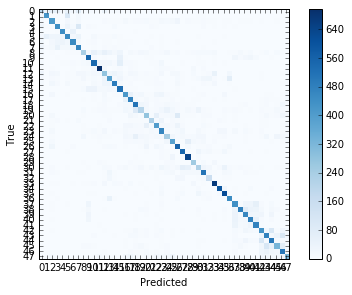

In [20]:
cls_true = b[160000:]
cls_pred = sess.run(tf.argmax(hypothesis, 1), feed_dict=test_feed_dict)
cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)        

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.tight_layout()
plt.colorbar()
tick_marks = np.arange(48)
plt.xticks(tick_marks, range(48))
plt.yticks(tick_marks, range(48))
plt.xlabel('Predicted')
plt.ylabel('True')

In [21]:
for i in range(48):
    print("[Accuracy: {:>.5f}] {}".format(cm[i][i] / d[i], c[i]))

[Accuracy: 0.28654] IT/과학-IT 일반
[Accuracy: 0.71864] IT/과학-게임/리뷰
[Accuracy: 0.61677] IT/과학-과학 일반
[Accuracy: 0.64110] IT/과학-모바일
[Accuracy: 0.84091] IT/과학-보안/해킹
[Accuracy: 0.61299] IT/과학-인터넷/SNS
[Accuracy: 0.69138] IT/과학-컴퓨터
[Accuracy: 0.68622] IT/과학-통신/뉴미디어
[Accuracy: 0.33475] 경제-경제 일반
[Accuracy: 0.72911] 경제-글로벌 경제
[Accuracy: 0.66790] 경제-금융
[Accuracy: 0.83573] 경제-부동산
[Accuracy: 0.38483] 경제-산업/재계
[Accuracy: 0.53635] 경제-생활경제
[Accuracy: 0.65426] 경제-중기/벤처
[Accuracy: 0.70494] 경제-증권
[Accuracy: 0.58865] 사회-교육
[Accuracy: 0.69867] 사회-노동
[Accuracy: 0.70233] 사회-사건사고
[Accuracy: 0.31839] 사회-사회일반
[Accuracy: 0.44094] 사회-식품/의료
[Accuracy: 0.59892] 사회-언론
[Accuracy: 0.60332] 사회-인권/복지
[Accuracy: 0.62184] 사회-인물
[Accuracy: 0.37718] 사회-지역
[Accuracy: 0.61208] 사회-환경
[Accuracy: 0.74232] 생활/문화-건강정보
[Accuracy: 0.80438] 생활/문화-공연/전시
[Accuracy: 0.90336] 생활/문화-날씨
[Accuracy: 0.73410] 생활/문화-도로/교통
[Accuracy: 0.34101] 생활/문화-생활문화 일반
[Accuracy: 0.70621] 생활/문화-여행/레저
[Accuracy: 0.57091] 생활/문화-음식/맛집
[Accuracy: 0.84284] 생활/문화-자동